# Notes

The sixth iteration of the modeling:
- prepare data split between series of HB sessions:
- - validation patients with multiple sessions
- - training patient with one sessions
- train classification
- train regression
- validate
        

In [41]:
import os 
import re
import csv
import json
import math
import random
import time

from itertools import chain
from datetime import datetime

import pandas as pd
import numpy as np
import tensorflow as tf

from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.metrics import r2_score, mean_absolute_error, classification_report

import matplotlib.pyplot as plt
plt.style.use('_mpl-gallery')

Start time

In [42]:
TIME = {}

TIME['start'] = time.time()

# Constants

In [43]:
SEQ_MAX_LEN = 800
NUM_CLASSES = 6
NUM_EXERCISES = 9
NUM_FLAG_BS = 2

In [44]:
dir_root = os.path.join('..')
dir_data_root = os.path.join(dir_root, 'data')
dir_exercises = os.path.join(dir_data_root, 'json', 'patients')

# Data prep

In [45]:
patients = {}
for file_name in os.listdir(dir_exercises):
    if file_name == '.DS_Store': continue
    
    file_path = os.path.join(dir_exercises, file_name)
    ids = file_name.split('_')
    patient_id = ids[0]
    data = json.load(open(file_path, 'r'))
    if patient_id not in patients:
        patients[patient_id] = {
            'exercise_meta': [],
            'session_meta': {},
        }

    patients[patient_id]['exercise_meta'].append(data['meta'])
    patients[patient_id]['session_meta'][data['meta']['id_sessions']] = {
        'evaluation': data['meta']['evaluation'],
        'session_date': data['meta']['session_date'],
    }

In [46]:
testing = []
training = []
for patient_id, data in patients.items():
    num_sessions = len(data['session_meta'])
    if num_sessions >= 3:
        testing.append(patient_id)
    else:
        training.append(patient_id)
        
print(f'Number of patients with one session: {len(training)}, with three or more sessions {len(testing)}')
#print(testing)

Number of patients with one session: 120, with three or more sessions 35


## Distribution of number of sessions

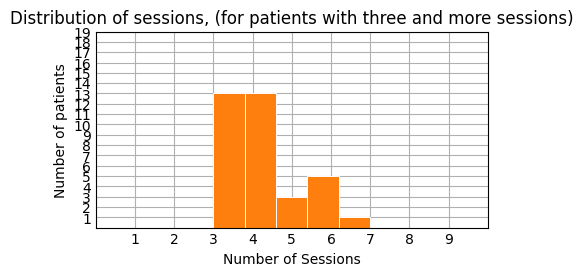

In [47]:
sessions_amounts = []
for patient_id in testing:
    sessions_meta = patients[patient_id]['session_meta']
    sessions_amounts.append(len(sessions_meta))

fig, ax = plt.subplots(figsize=(4,2)) 
#bars = ax.bar(x, sessions_amounts, color='tab:orange', edgecolor='white', linewidth=0.7)
ax.hist(sessions_amounts, color='tab:orange', edgecolor='white', linewidth=0.7, bins=5)

ax.set(
    xlim=(0, 10), 
    ylim=(0, 11),
    yticks=np.arange(1, 20),
    xticks=np.arange(1, 10),
    xlabel='Number of Sessions',
    ylabel='Number of patients',
    title=f'Distribution of sessions, (for patients with three and more sessions)'
)

plt.show() 

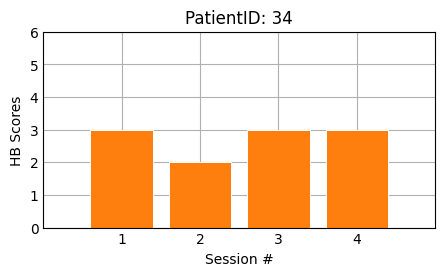

In [48]:
patient_id = '34'
patiens_sessions_data = patients[patient_id]['session_meta'].values()
exercises = [int(data['evaluation']) for data in sorted(patiens_sessions_data, key = lambda x: x['session_date'])]

fig, ax = plt.subplots(figsize=(4,2)) 
x = 1 + np.arange(len(exercises))
bars = ax.bar(x, exercises, color='tab:orange', edgecolor='white', linewidth=0.7)
    
ax.set(
    xlim=(0, len(exercises) + 1), 
    ylim=(0, 6),
    xticks=np.arange(1, len(exercises) + 1),
    xlabel='Session #',
    ylabel='HB Scores',
    title=f'PatientID: {patient_id}'
)

plt.show() 

## Build data set

In [49]:
TIME['data_processing_start'] = time.time()

In [50]:
from utils.input import setup, exercise_to_input

In [51]:
setup(os.path.join('..'), SEQ_MAX_LEN, NUM_EXERCISES, NUM_FLAG_BS)

print('complete')

complete


In [52]:
exercises_sources = [
    #dir_exercises_test
    dir_exercises,
    #dir_exercises_augmented
]

In [53]:
feature_engineering_setting = {
    'coordinates': True,
    'normalize_by_start': False,
    'normalize': False,
    'direction': False,
    'distance': False,
    'symetry_diference': False,
    're_base': True,
    'transformation_to_rebase': False,
    'extended_meta': True,
}

In [54]:
patient_input = {}
for exercise_source in exercises_sources:
    for file_name in os.listdir(exercise_source):
        file_path = os.path.join(exercise_source, file_name)

        if file_name == '.DS_Store': continue
        
        patient_id = file_name.split('_')[0]
        if patient_id not in patient_input:
            patient_input[patient_id] = []
            
        data = json.load(open(file_path, 'r'))
        
        _xs_meta, _xs_global, _xs_frontal, _xs_oral, _xs_orbital, _ys = exercise_to_input(file_path, feature_engineering_setting)
        patient_input[patient_id].append({
            'meta': data['meta'],
            'y': _ys,
            'x_meta': _xs_meta,
            'x_global': _xs_global,
            'x_frontal': _xs_frontal,
            'x_oral': _xs_oral,
            'x_orbital': _xs_orbital,
        })

Time preprocessing

In [55]:
TIME['data_processing_end'] = time.time()

# Modeling

In [56]:
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Conv1D
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling1D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import concatenate
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.optimizers import Adam

from sklearn.utils import class_weight

In [57]:
def get_dnn(inputLayer, region='default'):     
    m = Dense(4, activation="relu",name=f'{region}-Dense-1')(inputLayer)
    m = Model(inputs=inputLayer, outputs=m)

    return m

In [58]:
def get_cnn(inputLayer, region='default'):
    chanDim = -1    
    m = Conv1D(16, 3, padding='same', activation='relu', name=f'{region}-Convolution-1')(inputLayer)
    m = BatchNormalization(axis=chanDim, name=f'{region}-Normalization-1')(m)
    m = MaxPooling1D((2), name=f'{region}-Pooling-1')(m)
    m = Conv1D(32, 3, padding='same', activation='relu', name=f'{region}-Convolution-2')(m)
    m = BatchNormalization(axis=chanDim, name=f'{region}-Normalization-2')(m)
    m = MaxPooling1D((2), name=f'{region}-Pooling-2')(m)
    m = Conv1D(64, 3, padding='same', activation='relu', name=f'{region}-Convolution-3')(m)
    m = BatchNormalization(axis=chanDim, name=f'{region}-Normalization-3')(m)
    m = MaxPooling1D((2), name=f'{region}-Pooling-3')(m)
    #m = Conv1D(64, 3, padding='same', activation='relu', name=f'{region}-Convolution-4')(m)
    #m = BatchNormalization(axis=chanDim, name=f'{region}-Normalization-4')(m)
    #m = MaxPooling1D((2), name=f'{region}-Pooling-4')(m)
    m = Flatten(name=f'{region}-Flatten-1')(m)
    m = Dropout(0.3, name=f'{region}-Dropout-1')(m)
    m = Dense(128, activation="relu", name=f'{region}-Dense-1')(m)
    m = Model(inputs=inputLayer, outputs=m)

    return m

In [59]:
def get_model_classification(meta_shape, global_shape, frontal_shape, oral_shape, orbital_shape):
    input_meta = Input(shape=meta_shape, name='Meta-Input')
    model_meta = get_dnn(input_meta, region='Meta')
    
    input_global = Input(shape=global_shape, name='Global-Input')
    model_global = get_cnn(input_global, region='Global')
    
    input_frontal = Input(shape=frontal_shape, name='Frontal-Input')
    model_frontal = get_cnn(input_frontal, region='Frontal')  

    input_oral = Input(shape=oral_shape, name='Oral-Input')
    model_oral = get_cnn(input_oral, region='Oral')  
    
    input_orbital = Input(shape=orbital_shape, name='Orbital-Input')
    model_orbital = get_cnn(input_orbital, region='Orbital')  
    
    
    model_contatenate = concatenate([
        model_meta.output, 
        model_global.output,
        model_frontal.output,
        model_oral.output,
        model_orbital.output,
    ])
    
    model_contatenate = Dense(32, activation="relu")(model_contatenate)
    model_contatenate = Dense(6, activation="softmax")(model_contatenate)
        
    model = Model(inputs=[
        model_meta.input,
        model_global.input,
        model_frontal.input,
        model_oral.input,
        model_orbital.input
    ], outputs=model_contatenate)

    model.compile(
        loss="sparse_categorical_crossentropy", 
        optimizer=Adam(learning_rate=1e-3, decay=1e-3 / 200),
        metrics=['accuracy']
    )
    
    
    return model

In [60]:
test_model = get_model_classification((52),(168, 800),(48, 800),(56, 800),(64, 800))
test_model.summary()

Model: "model_35"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 Global-Input (InputLayer)      [(None, 168, 800)]   0           []                               
                                                                                                  
 Frontal-Input (InputLayer)     [(None, 48, 800)]    0           []                               
                                                                                                  
 Oral-Input (InputLayer)        [(None, 56, 800)]    0           []                               
                                                                                                  
 Orbital-Input (InputLayer)     [(None, 64, 800)]    0           []                               
                                                                                           

# One out evaluation

In [61]:
VERBOSE = 1
EPOCHS = 200
BATCH_SIZE = 16
MODEL = 'CLASSIFICATION' #'REGRESSION'
OUTPUT_DIR = os.path.join(dir_data_root, 'results', 'fs_evaluation', 'run_class_001')


In [62]:
def error_size(ys, ys_pred):
    return [abs(y - y_p) for y, y_p in zip(ys, ys_pred)]

In [63]:
%matplotlib inline

(2383,)
(2383, 52)
(2383, 126, 800)
(2383, 36, 800)
(2383, 42, 800)
(2383, 48, 800)
(36,)
(36, 52)
(36, 126, 800)
(36, 36, 800)
(36, 42, 800)
(36, 48, 800)
[{'id': '01', 'tag': '01_RaisingEyebrows', 'name': 'RaisingEyebrows', 'evaluation': '3', 'age': 'None', 'sex': 'SexEnum.FEMALE', 'id_sessions': '194', 'session_date': '2020-11-12 10:08:59.346000'}, {'id': '05', 'tag': '05_BaringTeeth', 'name': 'BaringTeeth', 'evaluation': '2', 'age': 'None', 'sex': 'SexEnum.FEMALE', 'id_sessions': '193', 'session_date': '2020-08-27 08:24:02.279000'}, {'id': '04', 'tag': '04_Smiling', 'name': 'Smiling', 'evaluation': '3', 'age': 'None', 'sex': 'SexEnum.FEMALE', 'id_sessions': '192', 'session_date': '2020-05-26 10:00:03.899000'}, {'id': '09', 'tag': '09_RaisingEyebrowsPursingLips', 'name': 'RaisingEyebrowsPursingLips', 'evaluation': '2', 'age': 'None', 'sex': 'SexEnum.FEMALE', 'id_sessions': '193', 'session_date': '2020-08-27 08:24:02.279000'}, {'id': '08', 'tag': '08_ClosingEyesBaringTeeth', 'name': 

2024-12-16 16:00:22.986189: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


75/75 [==============================] - ETA: 0s - loss: 2.2183 - accuracy: 0.1713

2024-12-16 16:00:37.404692: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


75/75 [==============================] - 24s 163ms/step - loss: 2.2183 - accuracy: 0.1713 - val_loss: 1.8814 - val_accuracy: 0.0940
Epoch 2/200
75/75 [==============================] - 5s 70ms/step - loss: 2.0954 - accuracy: 0.1646 - val_loss: 1.8501 - val_accuracy: 0.0797
Epoch 3/200
75/75 [==============================] - 5s 71ms/step - loss: 2.0239 - accuracy: 0.1948 - val_loss: 1.9644 - val_accuracy: 0.0856
Epoch 4/200
75/75 [==============================] - 6s 78ms/step - loss: 2.0066 - accuracy: 0.1772 - val_loss: 1.9375 - val_accuracy: 0.0394
Epoch 5/200
75/75 [==============================] - 5s 69ms/step - loss: 1.9500 - accuracy: 0.1948 - val_loss: 2.2826 - val_accuracy: 0.0906
Epoch 6/200
75/75 [==============================] - 5s 73ms/step - loss: 1.9964 - accuracy: 0.1940 - val_loss: 2.2739 - val_accuracy: 0.1049
Epoch 7/200
75/75 [==============================] - 6s 73ms/step - loss: 1.8660 - accuracy: 0.2477 - val_loss: 2.1151 - val_accuracy: 0.1544
Epoch 8/200
75/7

2024-12-16 16:15:07.001480: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
/Users/alanchen/.local/share/virtualenvs/research-face-excercises-dynamics-o_HFBNSW/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/alanchen/.local/share/virtualenvs/research-face-excercises-dynamics-o_HFBNSW/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/alanchen/.local/share/virtualenvs/research-face-excercises-dynamics-o_HFBNSW/l

[[1.39208269e-05 7.86350718e-09 7.63783047e-12 2.43835105e-03
  6.66563892e-07 9.97546971e-01]
 [5.91677725e-01 4.04268622e-01 6.47776469e-04 5.13178904e-08
  3.08886869e-04 3.09693743e-03]
 [5.45583680e-06 9.99990940e-01 2.59665444e-06 6.51893205e-26
  5.22677794e-07 4.64149139e-07]
 [6.53729141e-02 9.11126852e-01 1.07310237e-02 1.85412330e-06
  8.95851571e-03 3.80895613e-03]
 [5.20558424e-05 9.99588192e-01 6.04926709e-06 3.35279751e-26
  2.30921185e-04 1.22719939e-04]
 [3.65513260e-04 9.97106493e-01 6.31950097e-05 4.66409671e-25
  5.35763917e-04 1.92904705e-03]
 [2.58895874e-01 5.31327605e-01 1.75257325e-02 7.19222669e-07
  1.01304814e-01 9.09452960e-02]
 [1.83601165e-04 9.99231100e-01 5.45122894e-04 4.13267088e-22
  1.14915599e-06 3.90731257e-05]
 [7.46519504e-08 8.84838658e-18 3.94974255e-13 9.99999881e-01
  1.26198719e-17 1.09626677e-16]
 [9.97299969e-01 2.68188934e-03 1.39540862e-05 2.85701546e-10
  3.16070964e-06 1.00865429e-06]
 [1.47679998e-02 1.94026929e-04 5.54923175e-15 1.8

/var/folders/v_/7lkrvbcs6612n3ydzvfv221c0000gn/T/ipykernel_3930/1775435660.py:233: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


 evaluation_metric: 0.049999999999999996
Done with evaluation for patient 34


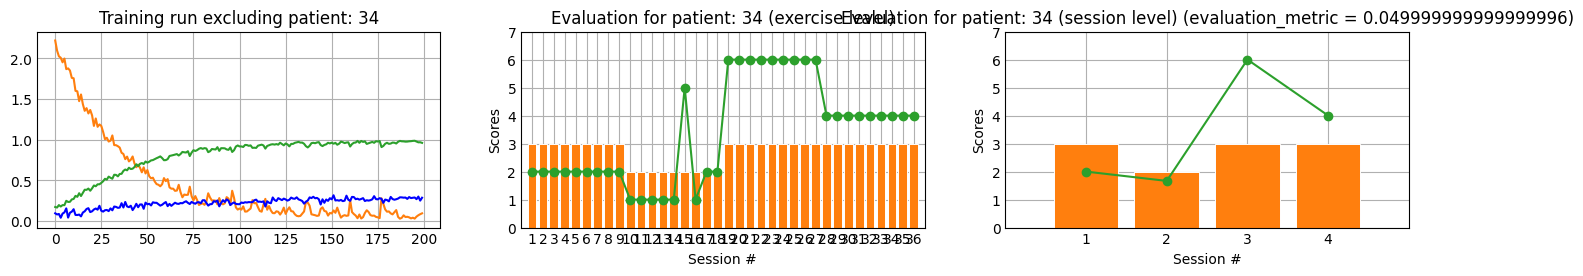

In [64]:
TIME['training_starts'] = time.time()

results = {}

TIME['training_start'] = time.time()

for test_parent_id in ['34']: #[]testing:
    xslist_meta = list()
    xslist_global = list()
    xslist_frontal = list()
    xslist_oral = list()
    xslist_orbital = list()
    yslist = list()

    xs_test_list_meta = list()
    xs_test_list_global = list()
    xs_test_list_frontal = list()
    xs_test_list_oral = list()
    xs_test_list_orbital = list()
    ys_test_list = list()
    test_meta_data = list()
    
    for parent_id in patient_input:
        if parent_id == test_parent_id:
            for exercise in patient_input[parent_id]:
                xs_test_list_meta.append(exercise['x_meta'])
                xs_test_list_global.append(exercise['x_global'])
                xs_test_list_frontal.append(exercise['x_frontal'])
                xs_test_list_oral.append(exercise['x_oral'])
                xs_test_list_orbital.append(exercise['x_orbital'])
                ys_test_list.append(exercise['y'])
                test_meta_data.append(exercise['meta'])
        else:
            for exercise in patient_input[parent_id]:
                xslist_meta.append(exercise['x_meta'])
                xslist_global.append(exercise['x_global'])
                xslist_frontal.append(exercise['x_frontal'])
                xslist_oral.append(exercise['x_oral'])
                xslist_orbital.append(exercise['x_orbital'])
                yslist.append(exercise['y']) 

        
    ys = np.array(yslist, dtype='int')
    xs_meta = np.array(xslist_meta, dtype='float32')   
    xs_global = np.array(xslist_global, dtype='float32') 
    xs_frontal = np.array(xslist_frontal, dtype='float32') 
    xs_oral = np.array(xslist_oral, dtype='float32') 
    xs_orbital = np.array(xslist_orbital, dtype='float32') 
    print(ys.shape)
    print(xs_meta.shape)
    print(xs_global.shape)
    print(xs_frontal.shape)
    print(xs_oral.shape)
    print(xs_orbital.shape)
    
    ys_test = np.array(ys_test_list, dtype='int')
    xs_test_meta = np.array(xs_test_list_meta, dtype='float32')   
    xs_test_global = np.array(xs_test_list_global, dtype='float32') 
    xs_test_frontal = np.array(xs_test_list_frontal, dtype='float32') 
    xs_test_oral = np.array(xs_test_list_oral, dtype='float32') 
    xs_test_orbital = np.array(xs_test_list_orbital, dtype='float32') 
    
    print(ys_test.shape)
    print(xs_test_meta.shape)
    print(xs_test_global.shape)
    print(xs_test_frontal.shape)
    print(xs_test_oral.shape)
    print(xs_test_orbital.shape)

    print(test_meta_data)
    
    weight_training_classes = None
    if MODEL == 'CLASSIFICATION':
        class_weights = class_weight.compute_class_weight(class_weight='balanced',
            classes = np.unique(ys),
            y=ys)
        
        available_classes = np.unique(ys)
        weight_training_classes = {
            0: 0,
            1: 0,
            2: 0,
            3: 0,
            4: 0,
            5: 0,
        }
        
        for indx, value in enumerate(class_weights):
            weight_training_classes[available_classes[indx]] = value

    print(weight_training_classes)
    
    ###### REGRESSION
    model = None
    if MODEL == 'REGRESSION':
        model = get_model_regression(xs_meta.shape[1:],xs_global.shape[1:],xs_frontal.shape[1:],xs_oral.shape[1:],xs_orbital.shape[1:])
    if MODEL == 'CLASSIFICATION':
        model = get_model_classification(xs_meta.shape[1:],xs_global.shape[1:],xs_frontal.shape[1:],xs_oral.shape[1:],xs_orbital.shape[1:])
        
    hist = model.fit(
        x=[
            xs_meta, 
            xs_global, 
            xs_frontal,
            xs_oral,
            xs_orbital
        ], 
        y=ys,
        validation_split=0.5,
        batch_size=BATCH_SIZE, 
        epochs=EPOCHS,
        class_weight=weight_training_classes,
        shuffle=True,
        verbose=VERBOSE)
    

    # visualizing losses and accuracy
    fig, axs = plt.subplots(1,3,figsize=(14,2)) 
    
    if MODEL == 'CLASSIFICATION':
        acuracy_label = {
            'history_key': 'accuracy',
            'label': 'Accuracy'
        }
    if MODEL == 'REGRESSION':
        acuracy_label = {
            'history_key': 'mae',
            'label': 'Accuracy (MAE)'
        }
    train_loss = hist.history['loss']
    train_acc  = hist.history[acuracy_label['history_key']]
    val_acc = hist.history['val_accuracy']
    xc         = np.arange(len(train_loss))
    
    axs[0].set_title(f'Training run excluding patient: {test_parent_id}')
    axs[0].plot(xc, train_loss, color='tab:orange', label='Loss')
    axs[0].plot(xc, train_acc, color='tab:green', label=acuracy_label['label'])
    axs[0].plot(xc, val_acc, color='blue', label='Validation Accuracy')

    # evaluation
    y_output = model.predict([
        xs_test_meta,
        xs_test_global,
        xs_test_frontal,
        xs_test_oral,
        xs_test_orbital],verbose=0)
    y_pred = None
    evaluation_metric = None
    if MODEL == 'REGRESSION':
        y_pred = [x[0] for x in y_output]
        evaluation_metric = mean_absolute_error(ys_test, y_pred)   
    if MODEL == 'CLASSIFICATION':
        y_pred_softmax = model.predict([
            xs_test_meta,
            xs_test_global,
            xs_test_frontal,
            xs_test_oral,
            xs_test_orbital],verbose=0)
        y_pred = np.argmax(y_pred_softmax, axis=1)
        report = classification_report(ys_test, y_pred, output_dict=True)
        evaluation_metric = report['weighted avg']['f1-score']
        print(y_pred_softmax)
        print(y_pred)
        print(report)

        
    ## visualizing HB vs Prediction on excercise level
    result = [
        {
        'fs': y + 1, 
        'id': meta['id'], 
        'evaluation': int(meta['evaluation']), 
        'id_sessions': meta['id_sessions'],
        'session_date': meta['session_date']
        } 
        for y, meta in zip(y_pred, test_meta_data)
        ]
    result.sort(key = lambda x: (x['session_date'], x['id']))
    
    evaluations = [int(x['evaluation']) for x in result]
    fine_scores = [float(x['fs']) for x in result]
    xc = 1 + np.arange(len(evaluations))
    
    #print(f'size evaluations {len(evaluations)} evaluations: {evaluations}')
    #print(f'size fine_scores {len(fine_scores)} fine_scores: {fine_scores}')
    #print(f'size xc {len(xc)} fine_scores: {xc}')
    
    
    axs[1].bar(xc, evaluations, color='tab:orange', edgecolor='white', linewidth=0.7)
    axs[1].plot(xc, fine_scores, color='tab:green', linestyle='-', marker='o')   
    axs[1].set(
        xlim=(0, len(evaluations) + 1), 
        ylim=(0, 7),
        xticks=np.arange(1, len(evaluations) + 1),
        xlabel='Session #',
        ylabel='Scores',
        title=f'Evaluation for patient: {test_parent_id} (exercise level)'
    )
    
    aggregate_result = {}
    for exercise in result:
        if exercise['id_sessions'] not in aggregate_result:
            aggregate_result[exercise['id_sessions']] = {
                'evaluation': exercise['evaluation'],
                'session_date': exercise['session_date'],
                'fs': []
            }
        aggregate_result[exercise['id_sessions']]['fs'].append(exercise['fs'])
        
    aggregate_result_sorted = [
        {
            'evaluation': x['evaluation'], 
            'fs': sum(x['fs'])/len(x['fs'])
        } 
        for x in sorted(aggregate_result.values(), key = lambda x: x['session_date'])]        
                               
    evaluations_sessions = [int(x['evaluation']) for x in aggregate_result_sorted]
    fine_scores_sessions = [float(x['fs']) for x in aggregate_result_sorted]
    xc_sessions = 1 + np.arange(len(evaluations_sessions))

    axs[2].bar(xc_sessions, evaluations_sessions, color='tab:orange', edgecolor='white', linewidth=0.7)
    axs[2].plot(xc_sessions, fine_scores_sessions, color='tab:green', linestyle='-', marker='o')   
    axs[2].set(
        xlim=(0, len(evaluations_sessions) + 1), 
        ylim=(0, 7),
        xticks=np.arange(1, len(evaluations_sessions) + 1),
        xlabel='Session #',
        ylabel='Scores',
        title=f'Evaluation for patient: {test_parent_id} (session level) (evaluation_metric = {evaluation_metric})'
    )
    
    fig.savefig(os.path.join(OUTPUT_DIR, f'evaluation_patient{test_parent_id}_{int(time.time())}.svg'), format='svg', dpi=600) 
    fig.show() 
    
    print(f' evaluation_metric: {evaluation_metric}')
    print(f'Done with evaluation for patient {test_parent_id}')

    data_result = {
        'evaluations_sessions': evaluations_sessions,
        'fine_scores_sessions': fine_scores_sessions,
        'evaluations_exercises': evaluations,
        'fine_scores_exercises': fine_scores,
        'training_size': len(ys),
        'testing_size': len(ys_test),
        'evaluation_metric': evaluation_metric
    }
    json.dump(data_result, open(os.path.join(OUTPUT_DIR, f'evaluation_patient{test_parent_id}_{int(time.time())}.json') ,'w'))

TIME['training_ends'] = time.time()  

End time

In [65]:
TIME['end'] = time.time()

In [66]:
print(f'Total processing took {TIME["end"] - TIME["start"]}')
print(f'Data processing took {TIME["data_processing_end"] - TIME["data_processing_start"]}')
print(f'Training took {TIME["training_ends"] - TIME["training_starts"]}')
print(f'Average training time {(TIME["training_ends"] - TIME["training_starts"])/len(testing)}')

Total processing took 937.8862080574036
Data processing took 29.442153930664062
Training took 898.1103329658508
Average training time 25.66029522759574


In [67]:
regression results time
Total processing took 78480.90524077415
Data processing took 22.376033067703247
Training took 78439.17259001732
Average training time 2241.1192168576376

SyntaxError: invalid syntax (1419136348.py, line 1)